In [1]:
import os
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pandas as pd
import random
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
%matplotlib inline

In [2]:
path_to_simu_1 = '../data/simu_graph/simu_genders/0/noise_500,outliers_varied/graphs/'
path_to_simu_2 = '../data/simu_graph/simu_genders/1/noise_500,outliers_varied/graphs/'

In [3]:
list_graphs_simu_1 = gp.load_graphs_in_list(path_to_simu_1)
list_graphs_simu_2 = gp.load_graphs_in_list(path_to_simu_2)

In [4]:
simu_train_set_mix = list_graphs_simu_1[:500] + list_graphs_simu_2[:500]  # mixed training set
simu_train_label_mix = list(np.zeros([500]))  + list(np.ones([500]))  # mixed label set

In [5]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [6]:
# Convert networkx graphs to pyg graphs

sulcal_simu_dataset = []

for i,g in enumerate(simu_train_set_mix):
    graph_remove_dummy_nodes(g) # remove dummy nodes
    g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    
    attr_coords = np.array(list(nx.get_node_attributes(g,'coord').values())) #simu attribute (coords)
    #attr_basin_area = np.array(list(nx.get_node_attributes(g,'basin_area').values())).reshape([len(g),1])
    #attr_basin_thickness = np.array(list(nx.get_node_attributes(g,'basin_thickness').values())).reshape([len(g),1])
    #attr_depth = np.array(list(nx.get_node_attributes(g,'depth').values())).reshape([len(g),1])
    
    #attr_concat = np.concatenate((attr_coords,attr_basin_area,attr_basin_thickness,attr_depth),axis = 1)
    
    x = torch.tensor(attr_coords,dtype=torch.float)
    
    #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    
    y = torch.tensor(simu_train_label_mix[i],dtype=torch.long) # add graph label
    edge_index = torch.tensor(list(g.edges))
    
    sulcal_simu_dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))
    
    #sulcal_dataset.append(from_networkx(g))

/tmp/ipykernel_133042/3794505539.py:20: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(simu_train_label_mix[i],dtype=torch.long) # add graph label


In [7]:
random.shuffle(sulcal_simu_dataset)

train_dataset = sulcal_simu_dataset[:600]
test_dataset = sulcal_simu_dataset[600:]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [8]:
num_node_features = train_dataset[0].num_features
num_node_features

3

In [9]:
len(sulcal_simu_dataset)

1000

In [10]:
# Create GAT Model

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):        
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.in_head = 2
        self.out_head = 1
        
        self.emb_dim = 8
        
        
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=self.in_head)
        self.conv2 = GATConv(hidden_channels*self.in_head, hidden_channels,concat=False)
        self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
        self.lin = Linear(self.emb_dim, 2)
        

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        emb,attn_weights = self.conv3(x, edge_index,return_attention_weights=True)

        # 2. Readout layer
        g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels] TopKPooling
        #g_emb = TopKPooling(emb, batch)

        # 3. Apply a final classifier
        out = F.dropout(g_emb, p=0.5, training=self.training)
        out = self.lin(out)
        
        return out, g_emb, emb, attn_weights

model = GAT(hidden_channels=32)
print(model)

GAT(
  (conv1): GATConv(3, 32, heads=2)
  (conv2): GATConv(64, 32, heads=1)
  (conv3): GATConv(32, 8, heads=1)
  (lin): Linear(in_features=8, out_features=2, bias=True)
)


In [11]:
#model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        out,g_emb,n_emb,_ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out,g_emb,emb,_ = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [12]:
for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.9933, Test Acc: 0.9950
Epoch: 002, Train Acc: 0.9900, Test Acc: 0.9925
Epoch: 003, Train Acc: 0.9967, Test Acc: 0.9975
Epoch: 004, Train Acc: 0.9467, Test Acc: 0.9700
Epoch: 005, Train Acc: 0.9967, Test Acc: 0.9950
Epoch: 006, Train Acc: 0.9983, Test Acc: 0.9975
Epoch: 007, Train Acc: 0.9733, Test Acc: 0.9675
Epoch: 008, Train Acc: 1.0000, Test Acc: 0.9975
Epoch: 009, Train Acc: 0.9933, Test Acc: 0.9850
Epoch: 010, Train Acc: 0.9983, Test Acc: 0.9950
Epoch: 011, Train Acc: 0.9900, Test Acc: 0.9950
Epoch: 012, Train Acc: 1.0000, Test Acc: 0.9950
Epoch: 013, Train Acc: 0.9950, Test Acc: 0.9950
Epoch: 014, Train Acc: 0.9950, Test Acc: 0.9950
Epoch: 015, Train Acc: 0.9983, Test Acc: 0.9950
Epoch: 016, Train Acc: 0.9983, Test Acc: 1.0000
Epoch: 017, Train Acc: 0.9983, Test Acc: 0.9975
Epoch: 018, Train Acc: 0.9983, Test Acc: 1.0000
Epoch: 019, Train Acc: 0.9983, Test Acc: 0.9975
Epoch: 020, Train Acc: 0.9933, Test Acc: 0.9925
Epoch: 021, Train Acc: 0.9983, Test Acc:

### Evaluate on a seperate set

In [13]:
eval_set = list_graphs_simu_1[500:] + list_graphs_simu_2[500:]
eval_label = list(np.zeros([500]))  + list(np.ones([500])) 

In [14]:
sulcal_eval_set = []

for i,g in enumerate(eval_set):
    graph_remove_dummy_nodes(g) # remove dummy nodes
    g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    
    attr_coords = np.array(list(nx.get_node_attributes(g,'coord').values())) #simu attribute (coords) 
    x = torch.tensor(attr_coords,dtype=torch.float)

    #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    
    y = torch.tensor(eval_label[i],dtype=torch.long) # add graph label
    edge_index = torch.tensor(list(g.edges))
    
    sulcal_eval_set.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))

/tmp/ipykernel_133042/672913835.py:12: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(eval_label[i],dtype=torch.long) # add graph label


In [15]:
real_emb = []
  
all_graph = DataLoader(sulcal_eval_set, batch_size= len(sulcal_eval_set), shuffle=False)

for data in all_graph:
    prob,g_emb,out_emb,attn_weights = model(data.x, data.edge_index, data.batch)
    
out_emb = out_emb.detach().numpy()
g_emb = g_emb.detach().numpy()

In [16]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)

tsne_graph = tsne.fit_transform(g_emb)
tsne_graph.shape

(1000, 2)

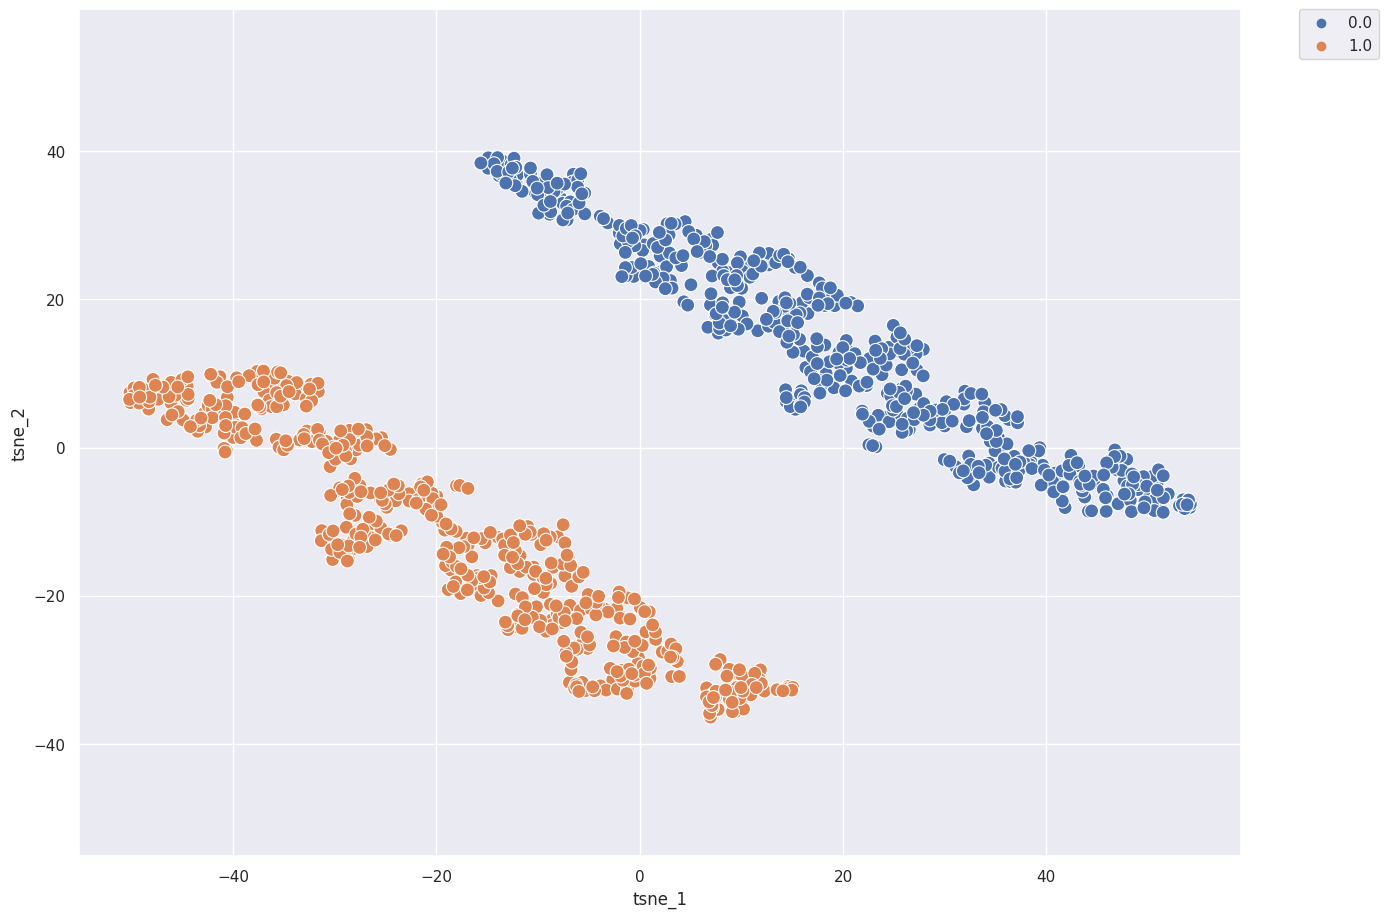

In [17]:
sns.set(rc={'figure.figsize':(15,11)})

tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':eval_label})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=100)

lim = (tsne_graph.min()-5, tsne_graph.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Compare with classical methods on simulations

In [18]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(g_emb, eval_label, test_size=0.7, random_state=42)

In [20]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [21]:
clf_svm = SVC(gamma='auto',kernel='linear').fit(X_train, y_train)
clf_svm.score(X_test, y_test)

1.0

In [22]:
clf_rf = RandomForestClassifier(max_depth = 2,random_state=0).fit(X_train, y_train)
clf_rf.score(X_test, y_test)

1.0

In [23]:
# On coordinates

In [24]:
avg_feature_coords = []

for d in sulcal_eval_set:
    avg_feature_coords.append(np.mean(d.x.detach().numpy(),axis=0))
    
avg_feature_coords = np.array(avg_feature_coords)

In [25]:
X_train_coords, X_test_coords, y_train_coords, y_test_coords = train_test_split(avg_feature_coords, eval_label, test_size=0.7, random_state=42)

In [26]:
clf_coord = LogisticRegression(random_state=0).fit(X_train_coords, y_train_coords)
clf_coord.score(X_test_coords, y_test_coords)

1.0

In [27]:
tsne_graph_coord = tsne.fit_transform(avg_feature_coords)

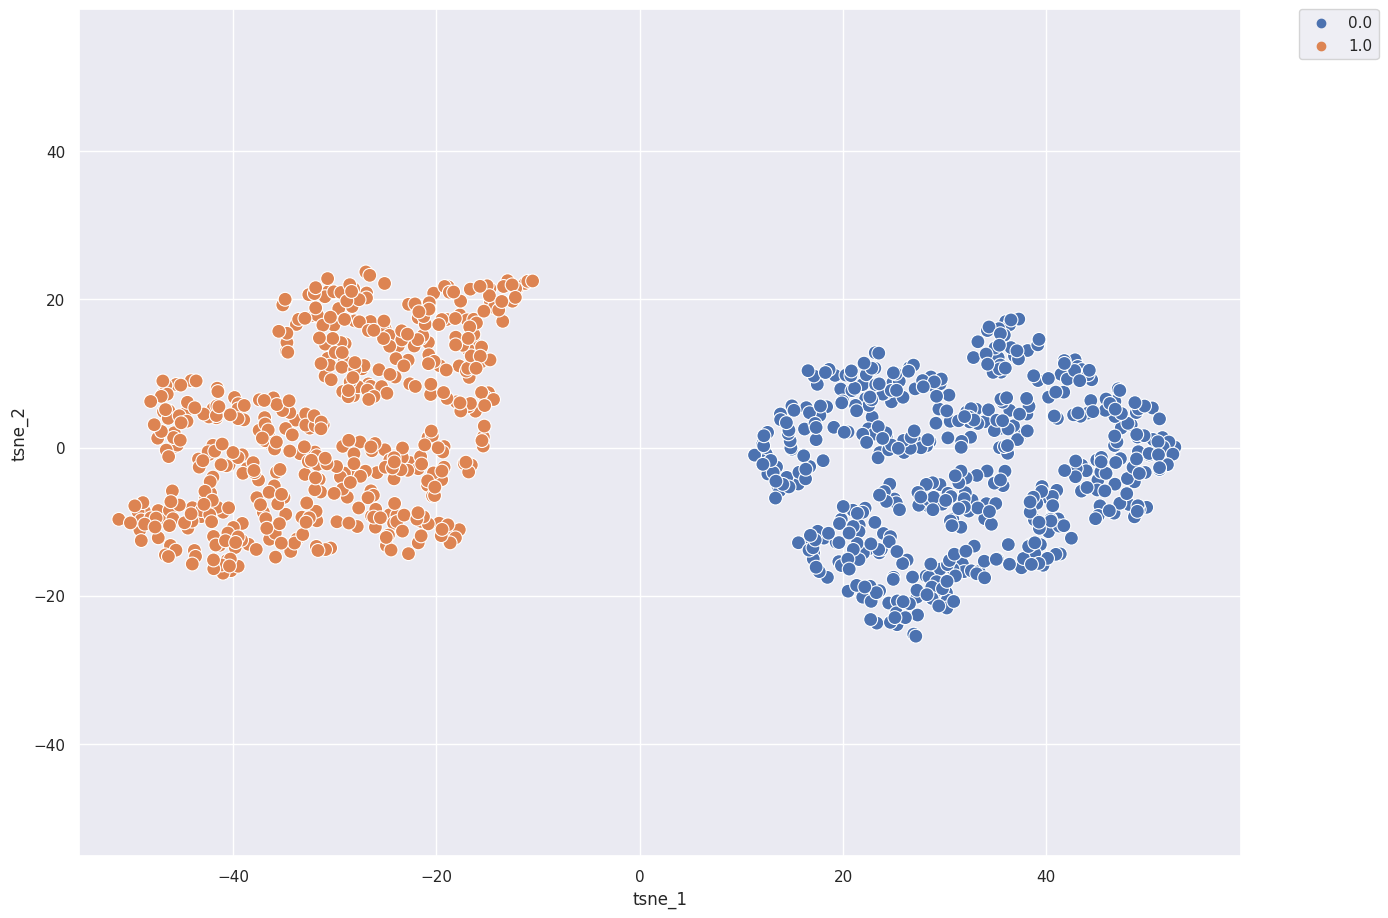

In [28]:
sns.set(rc={'figure.figsize':(15,11)})

tsne_graph_df_coord = pd.DataFrame({'tsne_1': tsne_graph_coord[:,0], 'tsne_2': tsne_graph_coord[:,1], 'label':eval_label})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df_coord, ax=ax,s=100)

lim = (tsne_graph.min()-5, tsne_graph.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)